## **Analisis Sentimen Ulasan Pengguna Aplikasi DANA Menggunakan NLP**

Aplikasi dompet digital seperti DANA kini menjadi solusi populer dalam melakukan transaksi digital di Indonesia. Banyaknya ulasan dari pengguna di Google Play Store memberikan informasi yang sangat berharga bagi pengembang untuk memahami kepuasan, keluhan, maupun harapan dari pengguna. Untuk itu, diperlukan analisis sentimen yang dapat mengklasifikasikan opini-opini tersebut ke dalam kategori positif, netral, atau negatif.

Proyek ini memanfaatkan pendekatan Natural Language Processing (NLP) dan deep learning untuk melakukan analisis terhadap lebih dari 12.000 ulasan pengguna aplikasi DANA. Proses dimulai dari pengambilan data ulasan secara otomatis, dilanjutkan dengan pembersihan data, tokenisasi teks, serta pelabelan sentimen berdasarkan skor rating. Model deep learning seperti CNN dan Bi-LSTM digunakan untuk melatih dan mengklasifikasikan data ulasan dengan akurasi tinggi.

Dengan adanya pemodelan ini, kita dapat memperoleh insight penting seperti persepsi masyarakat terhadap fitur aplikasi, permasalahan yang sering dihadapi, hingga bentuk apresiasi dari pengguna. Hasil analisis ini dapat dimanfaatkan oleh tim pengembang aplikasi DANA sebagai dasar dalam meningkatkan kualitas layanan dan pengalaman pengguna secara keseluruhan.


In [48]:
!pip install emoji
!pip install swifter
!pip install Sastrawi
!pip install google-play-scraper
!pip install wordcloud


In [49]:
# Mengimpor pustaka google_play_scraper untuk mengakses ulasan dan informasi aplikasi dari Google Play Store.
from google_play_scraper import app, reviews, Sort, reviews_all
import pandas as pd
import re
import string
import nltk
import emoji
import swifter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [50]:
# Download resource NLTK (jika belum)
nltk.download("stopwords")
nltk.download("punkt")
nltk.download('punkt_tab')

# Inisialisasi Sastrawi Stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Load dataset
df = pd.read_csv("ulasan_dana_12000.csv")

# Stopwords bahasa Indonesia
stop_words = set(stopwords.words("indonesian"))




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Loading Dataset

In [51]:
# Baca file CSV ke dalam DataFrame

# Cek jumlah baris dan kolom
df.shape

# Lihat 5 data teratas
df.head()

# Simpan ulang jika perlu (optional)
df.to_csv('ulasan_dana_12000.csv', index=False)

In [52]:
jumlah_ulasan, jumlah_kolom = df.shape
print(f"Jumlah data awal: {jumlah_ulasan} ulasan, {jumlah_kolom} kolom")

Jumlah data awal: 12000 ulasan, 11 kolom


In [53]:
# Menampilkan lima baris pertama dari DataFrame app_reviews_df
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,3c274eb3-4de3-41fd-85be-85fb22a55c8b,Ano Kustiawan,https://play-lh.googleusercontent.com/a-/ALV-U...,mengapa sangat sulit mengganti KTP padahal sem...,2,172,2.77.0,2025-03-29 16:56:30,NaN,NaN,2.77.0
1,7353dbaa-fb95-4532-bf3e-c04982995f12,Isro' Tantowi,https://play-lh.googleusercontent.com/a-/ALV-U...,"Akun tiba"" terhubung ke UC Drive Premium, Sald...",1,29,2.77.0,2025-04-03 05:24:42,NaN,NaN,2.77.0
2,3b8feda9-cfe9-43fb-b6e4-00c5f60d1fa9,Irawan mas IR,https://play-lh.googleusercontent.com/a-/ALV-U...,Emang aplikasi BUSUK.Saya transaksi sudah terj...,1,992,2.77.0,2025-03-27 18:49:41,"Hi Kak, maaf udah bikin kamu ga tenang. Terkai...",2025-03-11 18:25:35,2.77.0
3,1663d72b-322b-4c36-848e-1464c6d041c1,Nurwahyuningsih,https://play-lh.googleusercontent.com/a/ACg8oc...,"aplikasi ini sangat tidak kompeten. pertama, C...",1,2,2.77.0,2025-04-04 03:31:37,NaN,NaN,2.77.0
4,54d0d14b-4a3f-4cd3-986c-86b01db0eb01,Raihan Firdaus,https://play-lh.googleusercontent.com/a-/ALV-U...,"Koneksi gak jelas, koneksi gak stabil, gak bis...",2,324,2.74.0,2025-03-19 16:07:35,NaN,NaN,2.74.0


In [54]:
# Menampilkan informasi tentang DataFrame app_reviews_df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              12000 non-null  object
 1   userName              12000 non-null  object
 2   userImage             12000 non-null  object
 3   content               12000 non-null  object
 4   score                 12000 non-null  int64 
 5   thumbsUpCount         12000 non-null  int64 
 6   reviewCreatedVersion  11384 non-null  object
 7   at                    12000 non-null  object
 8   replyContent          5651 non-null   object
 9   repliedAt             5651 non-null   object
 10  appVersion            11384 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.0+ MB


In [55]:
clean_df = df

In [56]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              12000 non-null  object
 1   userName              12000 non-null  object
 2   userImage             12000 non-null  object
 3   content               12000 non-null  object
 4   score                 12000 non-null  int64 
 5   thumbsUpCount         12000 non-null  int64 
 6   reviewCreatedVersion  11384 non-null  object
 7   at                    12000 non-null  object
 8   replyContent          5651 non-null   object
 9   repliedAt             5651 non-null   object
 10  appVersion            11384 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.0+ MB


In [57]:
# Menghapus baris duplikat dari DataFrame clean_df
clean_df = clean_df.drop_duplicates()

# Menghitung jumlah baris dan kolom dalam DataFrame clean_df setelah menghapus duplikat
jumlah_ulasan_setelah_hapus_duplikat, jumlah_kolom_setelah_hapus_duplikat = clean_df.shape

## **PreProcessing**

In [58]:
# Tambahkan kata-kata yang ingin dihapus
custom_stopwords = {"yg", "nya", "gak", "aja", "href", "ga", "ya","br"}

# Kata yang ingin diganti
word_replacement = {
    "APK": "APLIKASI",
    "apk": "aplikasi"
}


# Fungsi untuk membersihkan teks
def clean_text(text):
    if isinstance(text, str):
        text = text.lower()  # Konversi ke huruf kecil
        text = re.sub(r"http\S+|www\S+", "", text)  # Hapus link
        text = re.sub(r"&\w+;", "", text)  # Hapus karakter HTML
        text = re.sub(r"<.*?>", "", text)  # Hapus tag HTML
        text = re.sub(r"[^\w\s]", "", text)  # Hapus tanda baca
        text = re.sub(r"\s+", " ", text).strip()  # Hapus spasi berlebih
        text = re.sub(r"\d+", "", text)  # Hapus angka
        text = re.sub(r"([!?.])\1+", r"\1", text)  # Hapus tanda baca berulang

        # Hapus emoji
        text = emoji.replace_emoji(text, replace="")

        # Tokenisasi
        words = word_tokenize(text)

        # Stopword removal (termasuk custom stopwords)
        words = [word for word in words if word not in stop_words and word not in custom_stopwords]

        # Ganti kata-kata tertentu
        words = [word_replacement.get(word, word) for word in words]

        # Stemming menggunakan Sastrawi
        words = [stemmer.stem(word) for word in words]

        return " ".join(words)
    return ""


In [59]:
df["Cleaned_Ulasan"] = df["content"].swifter.apply(clean_text)

Pandas Apply:   0%|          | 0/12000 [00:00<?, ?it/s]

In [60]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # remove mentions
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # remove hashtag
    text = re.sub(r'RT[\s]', '', text) # remove RT
    text = re.sub(r"http\S+", '', text) # remove link
    text = re.sub(r'[0-9]+', '', text) # remove numbers
    text = re.sub(r'[^\w\s]', '', text) # remove numbers


    text = text.replace('\n', ' ') # replace new line into space
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove all punctuations
    text = text.strip(' ') # remove characters space from both left and right text
    return text

def casefoldingText(text): # Converting all the characters in a text into lower case
    text = text.lower()
    return text

def tokenizingText(text): # Tokenizing or splitting a string, text into a list of tokens
    text = word_tokenize(text)
    return text

def filteringText(text): # Remove stopwors in a text
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text): # Reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words
    # Membuat objek stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # Memecah teks menjadi daftar kata
    words = text.split()

    # Menerapkan stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words]

    # Menggabungkan kata-kata yang telah distem
    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

    return stemmed_text
def toSentence(list_words): # Convert list of words into sentence
    sentence = ' '.join(word for word in list_words)
    return sentence

In [61]:
clean_df

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,3c274eb3-4de3-41fd-85be-85fb22a55c8b,Ano Kustiawan,https://play-lh.googleusercontent.com/a-/ALV-U...,mengapa sangat sulit mengganti KTP padahal sem...,2,172,2.77.0,2025-03-29 16:56:30,NaN,NaN,2.77.0
1,7353dbaa-fb95-4532-bf3e-c04982995f12,Isro' Tantowi,https://play-lh.googleusercontent.com/a-/ALV-U...,"Akun tiba"" terhubung ke UC Drive Premium, Sald...",1,29,2.77.0,2025-04-03 05:24:42,NaN,NaN,2.77.0
2,3b8feda9-cfe9-43fb-b6e4-00c5f60d1fa9,Irawan mas IR,https://play-lh.googleusercontent.com/a-/ALV-U...,Emang aplikasi BUSUK.Saya transaksi sudah terj...,1,992,2.77.0,2025-03-27 18:49:41,"Hi Kak, maaf udah bikin kamu ga tenang. Terkai...",2025-03-11 18:25:35,2.77.0
3,1663d72b-322b-4c36-848e-1464c6d041c1,Nurwahyuningsih,https://play-lh.googleusercontent.com/a/ACg8oc...,"aplikasi ini sangat tidak kompeten. pertama, C...",1,2,2.77.0,2025-04-04 03:31:37,NaN,NaN,2.77.0
4,54d0d14b-4a3f-4cd3-986c-86b01db0eb01,Raihan Firdaus,https://play-lh.googleusercontent.com/a-/ALV-U...,"Koneksi gak jelas, koneksi gak stabil, gak bis...",2,324,2.74.0,2025-03-19 16:07:35,NaN,NaN,2.74.0
...,...,...,...,...,...,...,...,...,...,...,...
11995,2f3b2164-8843-4bd4-ba9b-e31b69f49391,sinar photocopy,https://play-lh.googleusercontent.com/a/ACg8oc...,"Update terbaru masih banyak bug, dari loading ...",5,142,2.40.0,2023-08-05 05:16:46,"Makasih buat review nya, kalo ada keluhan hubu...",2023-08-05 05:18:18,2.40.0
11996,db95dcfe-f639-401f-9570-06ea7aa187cc,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Sistem transaksi yg baik,namun untuk riwayat t...",5,3,1.4.3,2019-10-27 12:45:54,NaN,NaN,1.4.3
11997,6e8de9a8-abfb-4557-9978-688b433b51c6,Fery Refansyah,https://play-lh.googleusercontent.com/a/ACg8oc...,Sebenarnya apl DANA ini sangat membantu sekali...,4,26,2.47.1,2023-11-23 12:03:07,"Hi Teman DANA, terima kasih atas ulasannya. DA...",2023-11-23 12:04:22,2.47.1
11998,b20031ef-058e-4b9b-a66a-0d23a724363d,Rinaldi Gazali,https://play-lh.googleusercontent.com/a/ACg8oc...,"Sangat kecewa sih, ini sudah dari kemarin coba...",1,5,1.26.1,2021-01-26 01:48:11,"Hi Kak, kami sangat memahami keluhan yang kamu...",2021-01-26 02:33:28,1.26.1


In [62]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
clean_df['text_clean'] = clean_df['content'].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText)


In [63]:
clean_df

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,text_clean,text_casefoldingText
0,3c274eb3-4de3-41fd-85be-85fb22a55c8b,Ano Kustiawan,https://play-lh.googleusercontent.com/a-/ALV-U...,mengapa sangat sulit mengganti KTP padahal sem...,2,172,2.77.0,2025-03-29 16:56:30,NaN,NaN,2.77.0,mengapa sangat sulit mengganti KTP padahal sem...,mengapa sangat sulit mengganti ktp padahal sem...
1,7353dbaa-fb95-4532-bf3e-c04982995f12,Isro' Tantowi,https://play-lh.googleusercontent.com/a-/ALV-U...,"Akun tiba"" terhubung ke UC Drive Premium, Sald...",1,29,2.77.0,2025-04-03 05:24:42,NaN,NaN,2.77.0,Akun tiba terhubung ke UC Drive Premium Saldo ...,akun tiba terhubung ke uc drive premium saldo ...
2,3b8feda9-cfe9-43fb-b6e4-00c5f60d1fa9,Irawan mas IR,https://play-lh.googleusercontent.com/a-/ALV-U...,Emang aplikasi BUSUK.Saya transaksi sudah terj...,1,992,2.77.0,2025-03-27 18:49:41,"Hi Kak, maaf udah bikin kamu ga tenang. Terkai...",2025-03-11 18:25:35,2.77.0,Emang aplikasi BUSUKSaya transaksi sudah terja...,emang aplikasi busuksaya transaksi sudah terja...
3,1663d72b-322b-4c36-848e-1464c6d041c1,Nurwahyuningsih,https://play-lh.googleusercontent.com/a/ACg8oc...,"aplikasi ini sangat tidak kompeten. pertama, C...",1,2,2.77.0,2025-04-04 03:31:37,NaN,NaN,2.77.0,aplikasi ini sangat tidak kompeten pertama CS ...,aplikasi ini sangat tidak kompeten pertama cs ...
4,54d0d14b-4a3f-4cd3-986c-86b01db0eb01,Raihan Firdaus,https://play-lh.googleusercontent.com/a-/ALV-U...,"Koneksi gak jelas, koneksi gak stabil, gak bis...",2,324,2.74.0,2025-03-19 16:07:35,NaN,NaN,2.74.0,Koneksi gak jelas koneksi gak stabil gak bisa ...,koneksi gak jelas koneksi gak stabil gak bisa ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,2f3b2164-8843-4bd4-ba9b-e31b69f49391,sinar photocopy,https://play-lh.googleusercontent.com/a/ACg8oc...,"Update terbaru masih banyak bug, dari loading ...",5,142,2.40.0,2023-08-05 05:16:46,"Makasih buat review nya, kalo ada keluhan hubu...",2023-08-05 05:18:18,2.40.0,Update terbaru masih banyak bug dari loading m...,update terbaru masih banyak bug dari loading m...
11996,db95dcfe-f639-401f-9570-06ea7aa187cc,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Sistem transaksi yg baik,namun untuk riwayat t...",5,3,1.4.3,2019-10-27 12:45:54,NaN,NaN,1.4.3,Sistem transaksi yg baiknamun untuk riwayat tr...,sistem transaksi yg baiknamun untuk riwayat tr...
11997,6e8de9a8-abfb-4557-9978-688b433b51c6,Fery Refansyah,https://play-lh.googleusercontent.com/a/ACg8oc...,Sebenarnya apl DANA ini sangat membantu sekali...,4,26,2.47.1,2023-11-23 12:03:07,"Hi Teman DANA, terima kasih atas ulasannya. DA...",2023-11-23 12:04:22,2.47.1,Sebenarnya apl DANA ini sangat membantu sekali...,sebenarnya apl dana ini sangat membantu sekali...
11998,b20031ef-058e-4b9b-a66a-0d23a724363d,Rinaldi Gazali,https://play-lh.googleusercontent.com/a/ACg8oc...,"Sangat kecewa sih, ini sudah dari kemarin coba...",1,5,1.26.1,2021-01-26 01:48:11,"Hi Kak, kami sangat memahami keluhan yang kamu...",2021-01-26 02:33:28,1.26.1,Sangat kecewa sih ini sudah dari kemarin coba ...,sangat kecewa sih ini sudah dari kemarin coba ...


##Pelabelan

In [64]:
kamus_positif = set([
    "bagus", "mantap", "mantul", "top", "cepat", "transaksi lancar", "aman", "terpercaya", "cashback", "promo",
    "diskon", "hemat", "praktis", "mudah", "simple", "user friendly", "fitur lengkap", "tidak lemot",
    "stabil", "update bagus", "pengalaman baik", "puas", "sangat membantu", "bantu banget", "berguna",
    "layanan memuaskan", "cs ramah", "pelayanan oke", "nyaman", "tidak ada kendala", "rekomendasi",
    "worth it", "gampang banget", "aplikasi oke", "responsif", "cepet banget", "top banget", "proses cepat",
    "gak ribet", "cukup baik", "oke punya", "pelayanan baik", "dapat cashback", "top markotop", "ga ada masalah",
    "tidak mengecewakan", "bagus banget", "sukses terus", "jempol", "sip lah", "oke banget", "sangat puas",
    "bagus sekali", "cocok", "puas banget", "dapat untung", "dapat hadiah", "bisa dipercaya", "bermanfaat",
    "berfungsi baik", "jalan lancar", "transaksi sukses", "cepat dan mudah", "tidak mengecewakan", "pelayanan cepat",
    "ga ribet banget", "praktikal", "bisa diandalkan", "apresiasi", "solusi", "pelayanannya keren", "joss",
    "good job", "very helpful", "helpful banget", "top service", "membantu sekali", "fast response",
    "lebih hemat", "bisa pakai terus", "tetap terbaik", "fitur kece", "layak dicoba", "recommended",
    "pengalaman memuaskan", "worth banget", "simple banget", "akses cepat", "fungsi optimal",
    "sangat stabil", "kerja bagus", "support cepat", "bantu banget", "ga nyesel", "terbantu", "oke lah","Aplikasinya bagus","keren","mudah","cepat","Aplikasi terbaik",
    "terbaik","sangat mudah","sangat membantu","nyaman","menarik"
])
kamus_negatif = set([
    "lemot", "lag", "crash", "error", "gagal", "fitur error", "tidak bisa login", "top up gagal",
    "saldo hilang", "transaksi gagal", "akun terblokir", "tidak bisa verifikasi", "gagal bayar",
    "fitur tidak jelas", "kena potong", "fitur tidak bisa digunakan", "tidak bisa digunakan",
    "tidak berguna", "update buruk", "tidak responsif", "server down", "lemot banget",
    "jelek", "tidak puas", "kecewa", "cs tidak membantu", "tidak dibalas", "tidak ditanggapi",
    "ga jelas", "gak bisa login", "fitur rusak", "kena tipu", "penipuan", "rugi", "susah",
    "tidak ramah", "ribet", "tidak praktis", "bug", "tidak stabil", "fitur terbatas",
    "banyak masalah", "error terus", "banyak gangguan", "bermasalah", "tidak jalan",
    "tidak bisa digunakan", "pengalaman buruk", "males banget", "ngelag terus", "tidak menyenangkan",
    "membingungkan", "banyak kekurangan", "tidak sesuai", "fitur susah dimengerti", "susah login",
    "penarikan gagal", "verifikasi susah", "tidak konsisten", "banyak potongan", "ga bisa verifikasi",
    "bikin ribet", "bikin kesel", "auto logout", "ga worth it", "tidak bisa akses", "saldo berkurang",
    "fitur tidak jalan", "tidak balance", "tidak ada respon", "pelayanan buruk", "support lambat",
    "tidak ramah", "gangguan terus", "sering eror", "proses lama", "pelayanan lambat",
    "notifikasi telat", "update bikin kacau", "gagal mulu", "sering gagal", "tidak disarankan",
    "ga bantu", "fitur ilang", "akun keblokir", "nggak worth", "gagal terus", "tidak sesuai harapan",
    "bikin jengkel", "tidak bisa digunakan", "data hilang", "bug terus", "sering crash",
    "gak bisa dipake", "kacau", "tidak nyaman", "trouble", "tidak worth it", "tidak layak""mengapa",
    "sulit","gagal","sudah","mencoba","namun","tidak memuaskan","tidak bisa",
    "hadeh","busuk","saldo gak masuk","sangat tidak","sulit dihubungi","gak jelas","najis","bug",
    "sering eror","ga bisa","gagal terus","sudah rugi","hack","tiba-tiba","merugikan","yang jelas",
    "kesedot","rawan penipuan","di hack","gajelas nih","diperbaiki","Aplikasi gak jelas","Sangat mengecewakan",
    "disuruh menunggu","kecewa","hilang tiba tiba","aplikasi busuk","kehilangan saldo","sangat buruk sekali"
])


In [65]:
def classify_text(text):
    text = text.lower()  # Ubah teks ke huruf kecil agar pencocokan tidak case-sensitive

    # Cek kata negatif
    for word in kamus_negatif:
        if re.search(r'\b' + re.escape(word) + r'\b', text):
            return "negatif"

    # Cek kata positif
    for word in kamus_positif:
        if re.search(r'\b' + re.escape(word) + r'\b', text):
            return "positif"

    return "netral"

In [66]:
# Terapkan fungsi sentimen
df["sentiment"] = df["Cleaned_Ulasan"].apply(classify_text)

In [67]:
# Hitung distribusi kelas sentimen
sentiment_counts = df["sentiment"].value_counts()

# Tampilkan hasil
print(sentiment_counts)


sentiment
netral     4725
negatif    3903
positif    3372
Name: count, dtype: int64


In [68]:
# Ambil contoh komentar Netral setelah perbaikan
neutral_comments = df[df["sentiment"] == "positif"]["Cleaned_Ulasan"].head(5)
print(neutral_comments.to_list())

['lemah dana fitur aman transaksi bayar qr pin akun dana login perangkat hp data login akses ubah pin verifikasi kode otp macam fitur scan wajah guna kecuali login perangkat proses verifikasi hilang saldo total k metode bayar qr akses lihat poin no', 'pakai setabil sih ditambahin kunci layar utama aman beli pulsa top up game bagus harga cocok kaum mendangmending pokok bessss', 'aplikasi aman muncul bayar maxtohub total ribu x kondisi hp buka dana bayar langgan engga maxtohub tau kaga maxtohub perhati dana simpan uang dana kosong sampe isi sedot', 'refresh lot update baru kirain cepat refresh simpan data ram langsung penuh update porsi device beda sering makan ruang simpan data ram device', 'aplikasi bagus tampil keren daftar ojk aman fitur fitur banyar mudah cepat nabung deposito pay later aman mudah belanja transmart allo bank diskon banget untung nyesel dowload aplikasi']


In [69]:
texts = [
"Aplikasi nya bagus,aman kok untuk digunakan"
]

for text in texts:
    print(f'"{text}" -> {classify_text(text)}')

"Aplikasi nya bagus,aman kok untuk digunakan" -> positif


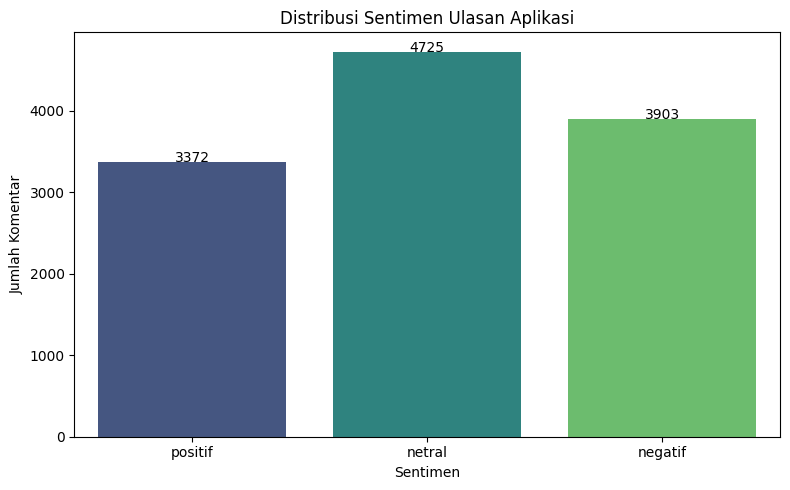

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

# Reorder indeks agar sesuai urutan yang diinginkan
ordered_sentiments = ["positif", "netral", "negatif"]
sentiment_counts = df["sentiment"].value_counts().reindex(ordered_sentiments, fill_value=0)

# Plot Bar Chart
plt.figure(figsize=(8, 5))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")

# Tambahkan label dan judul
plt.xlabel("Sentimen")
plt.ylabel("Jumlah Komentar")
plt.title("Distribusi Sentimen Ulasan Aplikasi")

# Tambahkan nilai di atas batang
for i, val in enumerate(sentiment_counts.values):
    plt.text(i, val + 1, str(val), ha='center')

plt.tight_layout()

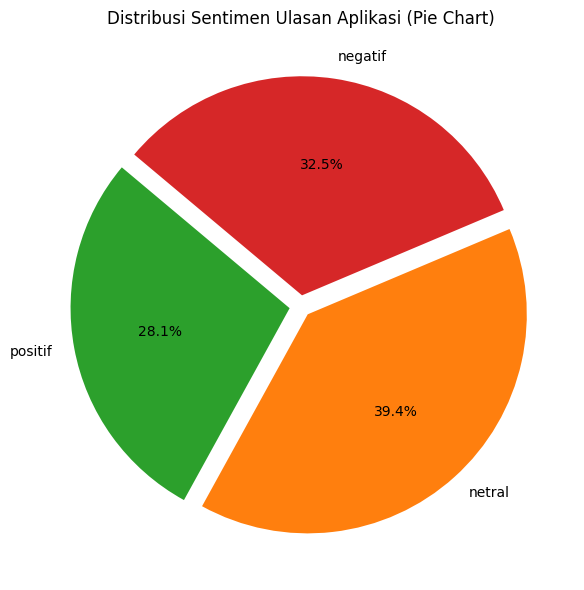

In [71]:
# Pie chart dengan urutan Positif, Netral, Negatif
plt.figure(figsize=(6, 6))
colors = ["#2ca02c", "#ff7f0e", "#d62728"]  # Hijau, oranye, merah

plt.pie(
    sentiment_counts.values,
    labels=sentiment_counts.index,
    autopct="%1.1f%%",
    startangle=140,
    colors=colors,
    explode=(0.05, 0.05, 0.05)
)

plt.title("Distribusi Sentimen Ulasan Aplikasi (Pie Chart)")
plt.tight_layout()
plt.show()

In [72]:
# Ambil contoh komentar Netral
neutral_comments = df[df["sentiment"] == "negatif"]["Cleaned_Ulasan"].head(50)
print(neutral_comments.to_list())

['sulit ganti ktp syarat penuh video ukur mb kirim gagal coba x ubah hasil muas solusi', 'akun hubung uc drive premium saldo potong aju kembali saldo dana lamalama ni aplikasi saldo potong aju kembali dana hadehh aplikasi busuk aplikasi haram terimakasih tidak nyaman', 'emang aplikasi busuksaya transaksi hasil bukti transaksi hasil saldo masukalias uang ilang emang bnyak sih kecewa ajaudah kali lho clear chace sudahupdate udahjaringan stabiltetep uang hilang transaksi uang isi hati hati guna dana hubung ana email respon download deh rugi', 'aplikasi kompeten cs sulit hubung cenderung bot masalah batas sesuai sistem sulit komunikasi icon beli voucher eplus gambar icon baca orangorang salah beli voucher jebak batman voucherpun tolong gambar icon ganti pilih voucher gambar lampu sulit beda voucher blypay send monney', 'koneksi koneksi stabil pakai data wifi kalo pakai data muncul koneksi putus palalo koneksi putus gw buka youtube k lancar dana najis jaring bug pake', 'develover aplikasi d

### **Word Cloud**

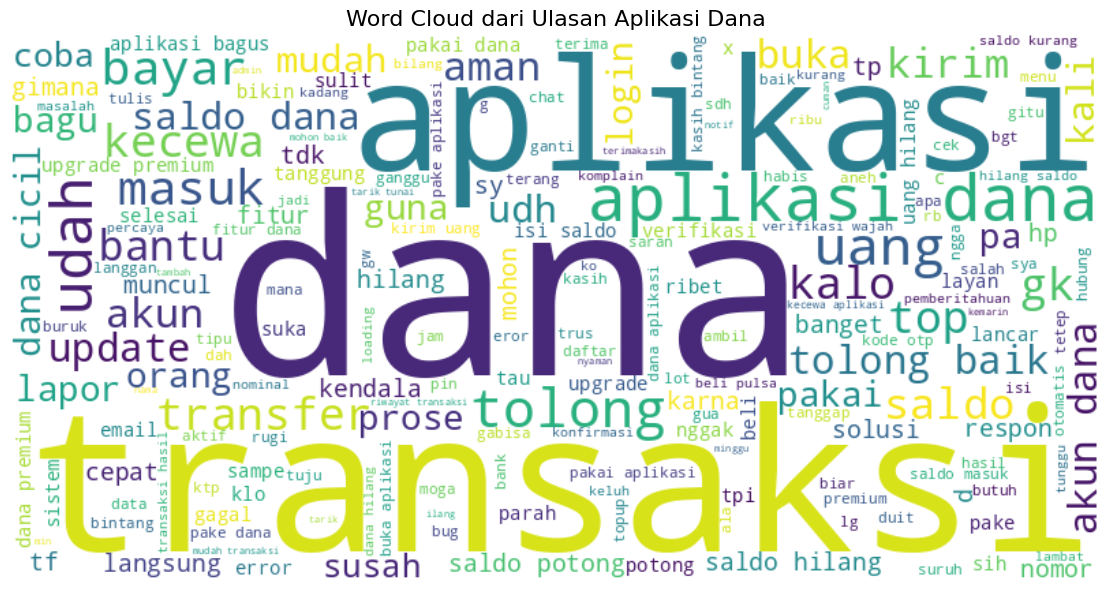

In [73]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Gabungkan semua teks dari kolom Cleaned_Ulasan
all_text = " ".join(df["Cleaned_Ulasan"].dropna().astype(str))

# Buat objek WordCloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white",
    colormap="viridis",
    max_words=200,
    contour_color='steelblue'
).generate(all_text)

# Tampilkan WordCloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud dari Ulasan Aplikasi Dana", fontsize=16)
plt.tight_layout()
plt.show()


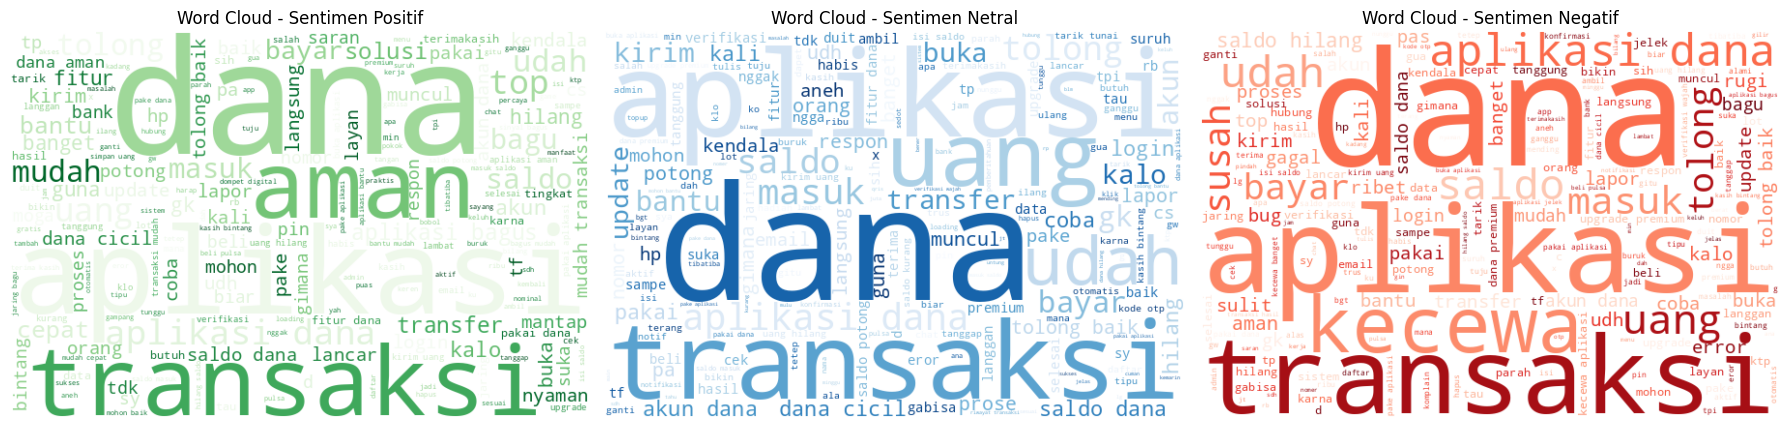

In [74]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Ambil teks berdasarkan sentimen
positive_text = " ".join(df[df["sentiment"] == "positif"]["Cleaned_Ulasan"].dropna().astype(str))
neutral_text = " ".join(df[df["sentiment"] == "netral"]["Cleaned_Ulasan"].dropna().astype(str))
negative_text = " ".join(df[df["sentiment"] == "negatif"]["Cleaned_Ulasan"].dropna().astype(str))

# Buat wordcloud untuk masing-masing sentimen
wordcloud_positive = WordCloud(width=600, height=400, background_color="white", colormap="Greens").generate(positive_text)
wordcloud_neutral  = WordCloud(width=600, height=400, background_color="white", colormap="Blues").generate(neutral_text)
wordcloud_negative = WordCloud(width=600, height=400, background_color="white", colormap="Reds").generate(negative_text)

# Tampilkan dalam 1 figure
plt.figure(figsize=(18, 6))

# Positif
plt.subplot(1, 3, 1)
plt.imshow(wordcloud_positive, interpolation="bilinear")
plt.title("Word Cloud - Sentimen Positif")
plt.axis("off")

# Netral
plt.subplot(1, 3, 2)
plt.imshow(wordcloud_neutral, interpolation="bilinear")
plt.title("Word Cloud - Sentimen Netral")
plt.axis("off")

# Negatif
plt.subplot(1, 3, 3)
plt.imshow(wordcloud_negative, interpolation="bilinear")
plt.title("Word Cloud - Sentimen Negatif")
plt.axis("off")

plt.tight_layout()
plt.show()


In [75]:
wordcloud_positive.to_file("wordcloud_positif.png")
wordcloud_neutral.to_file("wordcloud_netral.png")
wordcloud_negative.to_file("wordcloud_negatif.png")


#### **Class Distribusi**

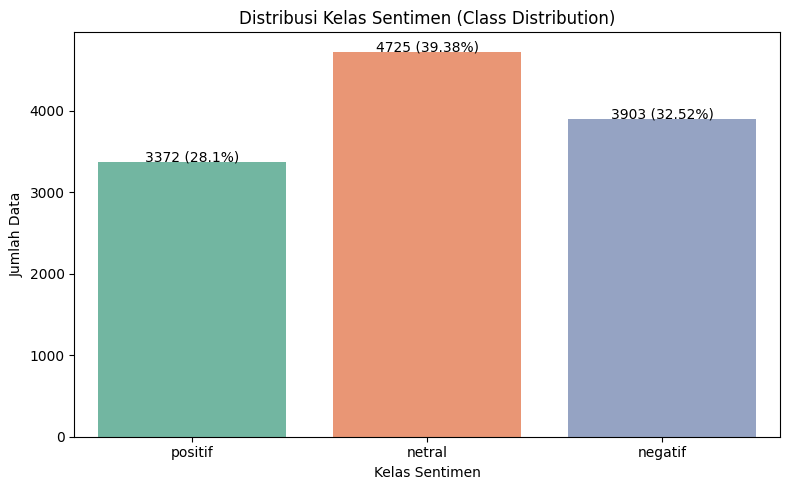

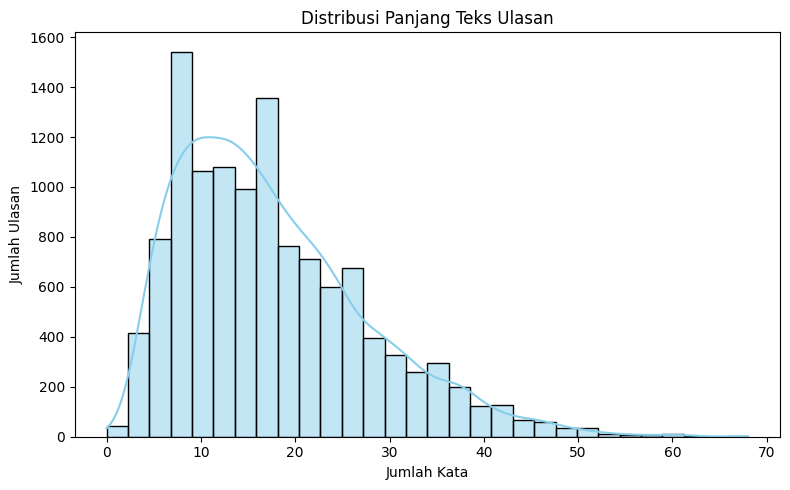

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

# Hitung distribusi kelas
class_counts = df["sentiment"].value_counts().reindex(["positif", "netral", "negatif"], fill_value=0)
total = class_counts.sum()
percentages = (class_counts / total * 100).round(2)

# Buat DataFrame ringkasan (opsional)
class_dist_df = class_counts.reset_index()
class_dist_df.columns = ['Sentimen', 'Jumlah']
class_dist_df['Persentase (%)'] = percentages.values

# Visualisasi
plt.figure(figsize=(8, 5))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="Set2")

# Tambahkan nilai dan persentase di atas batang
for i, (count, percent) in enumerate(zip(class_counts.values, percentages.values)):
    plt.text(i, count + 1, f"{count} ({percent}%)", ha='center', fontsize=10)

plt.xlabel("Kelas Sentimen")
plt.ylabel("Jumlah Data")
plt.title("Distribusi Kelas Sentimen (Class Distribution)")
plt.tight_layout()
plt.show()


# Tambahkan kolom panjang teks (berdasarkan jumlah kata)
df["text_length"] = df["Cleaned_Ulasan"].dropna().apply(lambda x: len(x.split()))

# Visualisasi distribusi panjang teks
plt.figure(figsize=(8, 5))
sns.histplot(df["text_length"], bins=30, kde=True, color="skyblue")
plt.title("Distribusi Panjang Teks Ulasan")
plt.xlabel("Jumlah Kata")
plt.ylabel("Jumlah Ulasan")
plt.tight_layout()
plt.show()



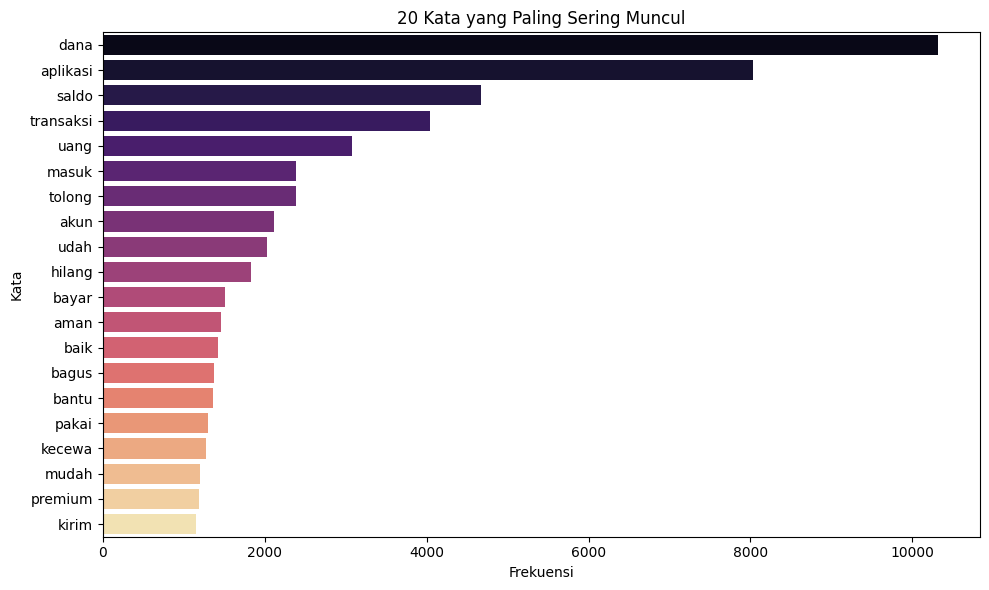

In [77]:
from collections import Counter

# Gabungkan semua teks menjadi satu string
all_words = " ".join(df["Cleaned_Ulasan"].dropna().astype(str)).split()

# Hitung frekuensi kata
word_freq = Counter(all_words)

# Ambil 20 kata paling sering
most_common_words = word_freq.most_common(20)

# Ubah ke DataFrame untuk visualisasi
common_words_df = pd.DataFrame(most_common_words, columns=["Kata", "Frekuensi"])

# Visualisasi
plt.figure(figsize=(10, 6))
sns.barplot(x="Frekuensi", y="Kata", data=common_words_df, palette="magma")
plt.title("20 Kata yang Paling Sering Muncul")
plt.xlabel("Frekuensi")
plt.ylabel("Kata")
plt.tight_layout()
plt.show()


In [78]:
df.to_csv("Label_sentiment.csv", index=False, encoding="utf-8")

# **Data Splitting**

In [79]:
!pip install gensim

In [80]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Bidirectional, Reshape
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Set random seed
tf.random.set_seed(42)

In [81]:
# Load dataset
df = pd.read_csv("Label_sentiment.csv")
df.dropna(inplace=True)


In [82]:
# Encode label
label_encoder = LabelEncoder()
df["sentiment"] = label_encoder.fit_transform(df["sentiment"])

# Split data
X_train, X_test, y_train, y_test = train_test_split(df["Cleaned_Ulasan"], df["sentiment"], test_size=0.2, stratify=df["sentiment"], random_state=42)
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

# Tokenization
vocab_size = 5000
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Apply tokenization and padding to X_train and X_test
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=100, padding='post', truncating='post')
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=100, padding='post', truncating='post')

In [83]:
# Callback untuk berhenti jika akurasi mencapai 95%
class StopAtAccuracy(Callback):
    def __init__(self, target_accuracy=0.94):
        super(StopAtAccuracy, self).__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_acc = logs.get("val_accuracy")
        if val_acc is not None and val_acc >= self.target_accuracy:
            print(f"\nStopping training as val_accuracy reached {val_acc:.4f} (≥ {self.target_accuracy})")
            self.model.stop_training = True

# **Pembuatan Model**

### **⚙️ Skema DL-1 : LSTM BI + Embedding**

In [84]:
# Model LSTM
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=100),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(3, activation="softmax")
])

early_stop_custom = StopAtAccuracy(target_accuracy=0.94)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [85]:
# Compile Model
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), metrics=["accuracy"])

# Latih model
history = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stop_custom])


Epoch 1/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 33s 107ms/step - accuracy: 0.4596 - loss: 1.0333 - val_accuracy: 0.7951 - val_loss: 0.5249
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8682 - loss: 0.3738
Stopping training as val_accuracy reached 0.9408 (≥ 0.94)
258/258 ━━━━━━━━━━━━━━━━━━━━ 28s 107ms/step - accuracy: 0.8684 - loss: 0.3734 - val_accuracy: 0.9408 - val_loss: 0.1839


In [86]:
# Evaluasi
train_acc = model.evaluate(X_train, y_train, verbose=0)[1]
test_acc = model.evaluate(X_test, y_test, verbose=0)[1]

print("LSTM - Training Accuracy:", round(train_acc * 100, 2), "%")
print("LSTM - Testing Accuracy :", round(test_acc * 100, 2), "%")

LSTM - Training Accuracy: 97.38 %
LSTM - Testing Accuracy : 94.08 %


In [87]:
# Evaluasi Model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_acc * 100:.2f}%")

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9411 - loss: 0.1845

Test Accuracy: 94.08%


### **⚙️ Skema DL-2: GRU (Gated Recurrent Unit)Tokenizer + Embedding Layer**

In [88]:
# Skema DL-2: GRU
model_gru = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=100),
    Bidirectional(GRU(128, return_sequences=False)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

model_gru.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

print("\n🧠 Training GRU Model...")
history_gru = model_gru.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[StopAtAccuracy(target_accuracy=0.94)],
    verbose=1
)

# Evaluasi GRU
train_loss_gru, train_acc_gru = model_gru.evaluate(X_train, y_train, verbose=0)
test_loss_gru, test_acc_gru = model_gru.evaluate(X_test, y_test, verbose=0)

print(f"\n✅ GRU Accuracy")
print(f"Training Accuracy: {train_acc_gru * 100:.2f}%")
print(f"Testing Accuracy : {test_acc_gru * 100:.2f}%")



🧠 Training GRU Model...
Epoch 1/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 43s 296ms/step - accuracy: 0.4520 - loss: 1.0150 - val_accuracy: 0.9029 - val_loss: 0.2617
Epoch 2/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.9341 - loss: 0.2120
Stopping training as val_accuracy reached 0.9485 (≥ 0.94)
129/129 ━━━━━━━━━━━━━━━━━━━━ 41s 296ms/step - accuracy: 0.9342 - loss: 0.2116 - val_accuracy: 0.9485 - val_loss: 0.1302

✅ GRU Accuracy
Training Accuracy: 97.21%
Testing Accuracy : 94.85%


### **⚙️ Skema DL-3: CNN + GlobalMaxPooling (TextCNN)Tokenizer + Trainable Embedding Layer**

In [89]:
# Skema DL-3: CNN + GlobalMaxPooling
model_cnn = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=100),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

model_cnn.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

print("\n🧠 Training CNN Model...")
history_cnn = model_cnn.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[StopAtAccuracy(target_accuracy=0.94)],
    verbose=1
)

# Evaluasi CNN
train_loss_cnn, train_acc_cnn = model_cnn.evaluate(X_train, y_train, verbose=0)
test_loss_cnn, test_acc_cnn = model_cnn.evaluate(X_test, y_test, verbose=0)

print(f"\n✅ CNN Accuracy")
print(f"Training Accuracy: {train_acc_cnn * 100:.2f}%")
print(f"Testing Accuracy : {test_acc_cnn * 100:.2f}%")



🧠 Training CNN Model...
Epoch 1/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - accuracy: 0.4570 - loss: 1.0271 - val_accuracy: 0.9204 - val_loss: 0.2462
Epoch 2/15
128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9318 - loss: 0.2148
Stopping training as val_accuracy reached 0.9825 (≥ 0.94)
129/129 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.9321 - loss: 0.2138 - val_accuracy: 0.9825 - val_loss: 0.0732

✅ CNN Accuracy
Training Accuracy: 99.00%
Testing Accuracy : 98.25%


In [90]:
# Evaluasi Model
def evaluate_model(model, X_test, y_test, name):
    loss, acc = model.evaluate(X_test, y_test)
    print(f"\n{name} Accuracy: {acc * 100:.2f}%")

evaluate_model(model, X_test, y_test, "LSTM")
evaluate_model(model_gru, X_test, y_test, "GRU ")
evaluate_model(model_cnn, X_test, y_test, "CNN")

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9411 - loss: 0.1845

LSTM Accuracy: 94.08%
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9482 - loss: 0.1338

GRU  Accuracy: 94.85%
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9800 - loss: 0.0779

CNN Accuracy: 98.25%


In [91]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Fungsi evaluasi dan visualisasi
def evaluate_model(model, X_test, y_test, model_name="Model"):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Classification report
    print(f"\n📊 Classification Report for {model_name}")
    print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step

📊 Classification Report for LSTM
              precision    recall  f1-score   support

     negatif       0.98      0.92      0.95       385
      netral       0.92      0.97      0.95       414
     positif       0.93      0.92      0.92       231

    accuracy                           0.94      1030
   macro avg       0.94      0.94      0.94      1030
weighted avg       0.94      0.94      0.94      1030



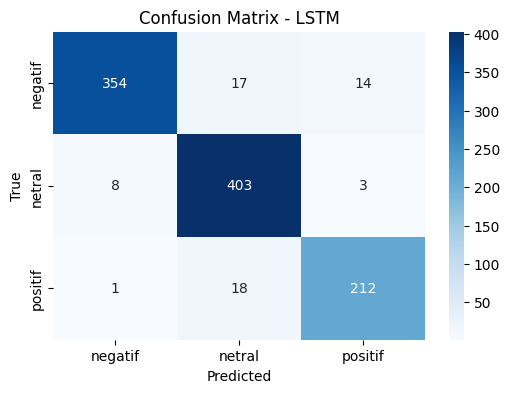

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step

📊 Classification Report for GRU
              precision    recall  f1-score   support

     negatif       0.93      0.97      0.95       385
      netral       0.97      0.93      0.95       414
     positif       0.95      0.95      0.95       231

    accuracy                           0.95      1030
   macro avg       0.95      0.95      0.95      1030
weighted avg       0.95      0.95      0.95      1030



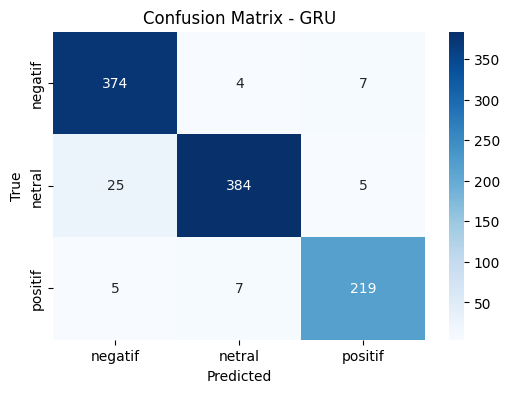

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step

📊 Classification Report for CNN
              precision    recall  f1-score   support

     negatif       0.98      0.99      0.99       385
      netral       0.98      0.98      0.98       414
     positif       1.00      0.97      0.98       231

    accuracy                           0.98      1030
   macro avg       0.98      0.98      0.98      1030
weighted avg       0.98      0.98      0.98      1030



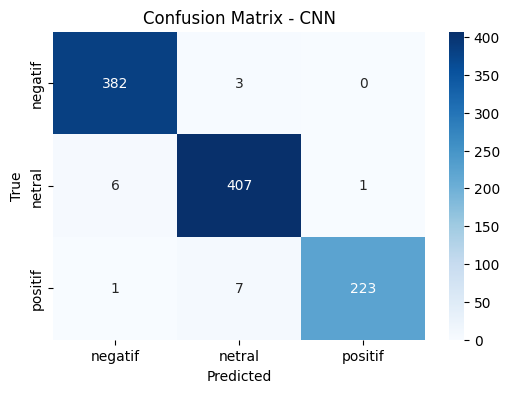

In [92]:
evaluate_model(model, X_test, y_test, "LSTM")
evaluate_model(model_gru, X_test, y_test, "GRU")
evaluate_model(model_cnn, X_test, y_test, "CNN")


# 📈 Evaluasi Performa Model Sentimen Aplikasi DANA

Berikut adalah hasil evaluasi akurasi dari tiga model deep learning yang digunakan untuk klasifikasi sentimen ulasan aplikasi DANA.

---

## 🔷 1. LSTM (Long Short-Term Memory)

- **Training Accuracy:** 97.38%
- **Testing Accuracy:** 94.08%

### 📌 Penjelasan:
Model LSTM mampu memahami konteks kalimat yang cukup panjang dan kompleks. Hasil akurasi training yang tinggi menunjukkan bahwa model belajar dengan baik selama pelatihan. Namun, akurasi testing sedikit lebih rendah, yang bisa mengindikasikan adanya sedikit overfitting — di mana model sangat cocok terhadap data latih tetapi tidak sebaik itu terhadap data baru.

---

## 🔶 2. GRU (Gated Recurrent Unit)

- **Training Accuracy:** 97.21%
- **Testing Accuracy:** 94.85%

### 📌 Penjelasan:
Model GRU menunjukkan performa yang hampir setara dengan LSTM pada data training, namun memiliki **akurasitas testing yang lebih tinggi**. Ini menunjukkan bahwa GRU memiliki kemampuan generalisasi yang lebih baik terhadap data baru dibandingkan LSTM. GRU juga lebih ringan secara komputasi dibanding LSTM, sehingga bisa menjadi alternatif yang efisien.

---

## 🔺 3. CNN (Convolutional Neural Network)

- **Training Accuracy:** 99.00%
- **Testing Accuracy:** 98.25%

### 📌 Penjelasan:
Model CNN memberikan performa terbaik di antara ketiganya, dengan akurasi sangat tinggi baik pada training maupun testing. Hal ini menunjukkan bahwa CNN sangat efektif dalam menangkap pola-pola lokal dari data teks (misalnya frasa-frasa penting yang menunjukkan sentimen). Model ini cocok jika ingin mengutamakan **akurasi tinggi dan prediksi yang stabil**.

---

## 🏁 Kesimpulan Akhir

| Model | Training Accuracy | Testing Accuracy | Keterangan |
|-------|-------------------|------------------|------------|
| **LSTM** | 97.38% | 94.08% | Baik untuk konteks panjang, sedikit overfitting |
| **GRU**  | 97.21% | 94.85% | Seimbang dan efisien |
| **CNN**  | 99.00% | 98.25% | Akurasi tertinggi, sangat andal |

> ✅ **Rekomendasi:** Jika tujuan utama adalah akurasi dan kestabilan prediksi, model **CNN** adalah pilihan terbaik. Namun jika membutuhkan efisiensi komputasi dan interpretasi sekuens, **GRU** bisa menjadi alternatif ringan yang tetap akurat.



### **Simpan Model ke File (.h5)**

In [93]:
# Simpan model
model.save("model_lstm.h5")
model_gru.save("model_gru.h5")
model_cnn.save("model_cnn.h5")


### **Simpan Tokenizer ke File (.pkl)**

In [94]:
import pickle

# Simpan tokenizer
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
